<a href="https://colab.research.google.com/github/GZHfighting/firsttry/blob/main/Classifier_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier using PyTorch

In this notebook we train an MLP classifier on the MINST dataset.

In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import os

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar 15 00:07:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# check if gpu/cpu
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

2.2.1+cu121
Using device: cuda


Load the MNIST dataset. This will download a copy to your machine on first use.

# Mount your google drive to save your results

In [ ]:
# Uncomment if you are using colab
from google.colab import drive
drive.mount('/content/drive')

# # mounted on MyDrive
!ls '/content/drive/'

Mounted at /content/drive
MyDrive


In [ ]:
# Define your result path in the Mydrive --> avoids re-running the same network after session

#ROOT = './'
# uncomment if you are using colab
ROOT = '/content/drive/MyDrive/'

DataPath = ROOT + 'Week2-data/'
ResultPath = ROOT + 'Week2-results/'

# make these directories if not available
# --> this will avoid you from downloading the data again and again
os.makedirs(DataPath, exist_ok=True)
os.makedirs(ResultPath, exist_ok=True)

In [ ]:
# Load the datasets
train_set = torchvision.datasets.MNIST(
    root=DataPath,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_set = torchvision.datasets.MNIST(
    root=DataPath,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Inspect some of the data.

In [ ]:
data, label = train_set[4]
print(data.size())
print(label)

torch.Size([1, 28, 28])
9


Create some iterable Data Loaders for easy iteration on mini-batches during training and testing. Also, initialise an array with the 10 class IDs.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = np.arange(0, 10)
print(classes)

[0 1 2 3 4 5 6 7 8 9]


Show some images and labels as a sanity check.
Use `torchvision.utils.make_grid` to create one image from a set of images. Note that this function converts single channel (grey-scale) tensors to have three channels. This is done by replicating the values into red, green and blue channels.

torch.Size([16, 1, 28, 28])


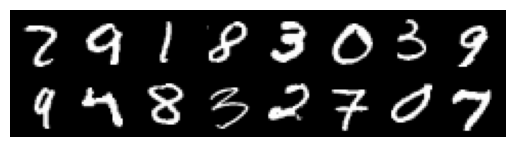

2 9 1 8 3 0 3 9 9 4 8 3 2 7 0 7


In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa

# get a batch of random training examples (images and corresponding labels)
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

# show images and labels
print(images.size())
timshow(torchvision.utils.make_grid(images))
print(*labels.numpy())     # asterisk unpacks the ndarray


## Implementing activation functions

In [ ]:
# Sigmoid function
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [ ]:
# use the above function to compute values for the following
print ("sigmoid(-0.1) = " + str(sigmoid(-0.1)))
print ("sigmoid(0.5) = " + str(sigmoid(0.5)))

sigmoid(-0.1) = 0.47502081252106
sigmoid(0.5) = 0.6224593312018546


In [ ]:
# TODO: Implement a ReLu activation function and evaluate for -0.1 and 0.5
### Your code here!
def relu(x):
    return max(0, x)

In [ ]:
print ("relu(-0.1) = " + str(relu(-0.1)))
print ("relu(0.5) = " + str(relu(0.5)))

relu(-0.1) = 0
relu(0.5) = 0.5


## Build a classifier
Instead of defining the classifier function, loss function and parameter updates directly as we did in PyTorch.ipynb, it is convenient to use the `torch.nn` and `torch.optim` packages. These provide a simple way to build networks without losing sight of the iterative steps in gradient descent.

First we construct the classifer function using the nn.Sequential wrapper that simply sequences the steps in the classifier function. In the case of a linear classifier there is just one nn.Linear layer. This is preceeded by `nn.Flatten` that vectorises a $28\times28$ input image into a 1D vector of length $28*28$. We will also experiment with a two layer classifier.

In [ ]:
net1 = nn.Sequential(
    nn.Flatten(),

    # single layer
    nn.Linear(28*28, 10)


)

for param in net1.parameters():
    print(param.shape)


torch.Size([10, 784])
torch.Size([10])


In [ ]:
net2 = nn.Sequential(
    nn.Flatten(),

    # single layer
    #nn.Linear(28*28, 10)

    # two layers
    nn.Linear(28*28, 300),
    nn.Sigmoid(),
    nn.Linear(300,10)
)

for param in net2.parameters():
    print(param.shape)

torch.Size([300, 784])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])


Train the network. For the two-layer network you'll need at least 200 epochs. 50 epochs will be more than enough for the one-layer network, but we'll run for the same number of epochs as for the two-layer network to give the full curve in the plot below.

In [ ]:
nepochs = 100    # number of epochs --> you can change as you want, for e.g., try 200 epochs
# define where you want to save your weights for 200 epochs, for example
# "always give proper names for your model" - here we have give "linear1layer200epochs.pt"
net = net1       # 1-layer model
results_path = ResultPath + 'linear1layer200epochs.pt'

# initialise ndarray to store the mean loss in each epoch (on the training data)
losses = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
# The chosen optimiser (Stochastic Gradient Descent with momentum) needs only to be given the parameters (weights and biases)
# of the network and updates these when asked to perform an optimisation step below.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0

    for data in train_loader:
        inputs, labels = data

        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1

    # record the mean loss for this epoch and show progress
    losses[epoch] = running_loss / n
    print(f"epoch: {epoch+1} loss: {losses[epoch] : .3f}")

# save network parameters and losses
torch.save({"state_dict": net.state_dict(), "losses": losses}, results_path)


epoch: 1 loss:  0.614
epoch: 2 loss:  0.390
epoch: 3 loss:  0.354
epoch: 4 loss:  0.336
epoch: 5 loss:  0.324
epoch: 6 loss:  0.316
epoch: 7 loss:  0.309
epoch: 8 loss:  0.304
epoch: 9 loss:  0.300
epoch: 10 loss:  0.296
epoch: 11 loss:  0.293
epoch: 12 loss:  0.291
epoch: 13 loss:  0.288
epoch: 14 loss:  0.286
epoch: 15 loss:  0.284
epoch: 16 loss:  0.283
epoch: 17 loss:  0.281
epoch: 18 loss:  0.280
epoch: 19 loss:  0.278
epoch: 20 loss:  0.277
epoch: 21 loss:  0.276
epoch: 22 loss:  0.275
epoch: 23 loss:  0.274
epoch: 24 loss:  0.273
epoch: 25 loss:  0.272
epoch: 26 loss:  0.271
epoch: 27 loss:  0.270
epoch: 28 loss:  0.270
epoch: 29 loss:  0.269
epoch: 30 loss:  0.268
epoch: 31 loss:  0.268
epoch: 32 loss:  0.267
epoch: 33 loss:  0.266
epoch: 34 loss:  0.266
epoch: 35 loss:  0.265
epoch: 36 loss:  0.265
epoch: 37 loss:  0.264
epoch: 38 loss:  0.264
epoch: 39 loss:  0.263
epoch: 40 loss:  0.263
epoch: 41 loss:  0.262
epoch: 42 loss:  0.262
epoch: 43 loss:  0.261
epoch: 44 loss:  0.2

In [ ]:
nepochs = 100   # number of epochs --> you can change as you want
net = net2       # 2-layer model
results_path = ResultPath + '/linear2layer200epochs.pt'

# initialise ndarray to store the mean loss in each epoch (on the training data)
losses = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
# The chosen optimiser (Stochastic Gradient Descent with momentum) needs only to be given the parameters (weights and biases)
# of the network and updates these when asked to perform an optimisation step below.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0

    for data in train_loader:
        inputs, labels = data

        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1

    # record the mean loss for this epoch and show progress
    losses[epoch] = running_loss / n
    print(f"epoch: {epoch+1} loss: {losses[epoch] : .3f}")

# save network parameters and losses
torch.save({"state_dict": net.state_dict(), "losses": losses}, results_path)

Notice that the first dimension of inputs and outputs corresponds to a minibatch of examples.

In [ ]:
print(f"input size: {inputs.size()}, output size: {outputs.size()}")

Compare the history of the loss function during training (mean loss in each epoch) for 1 and 2 layer models

In [ ]:
d1 = torch.load(ResultPath +  'linear1layer200epochs.pt')
d2 = torch.load(ResultPath + 'linear2layer200epochs.pt')

fig = plt.figure()

plt.plot(d1["losses"], 'r', label = '1 layer', )
plt.plot(d2["losses"], 'g', label = '2 layers' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss for 1 and 2 layer classifiers')

fig.savefig(ResultPath + "training_loss_MNIST.svg")
plt.show()

How does the trained classifier `net` perform on the test set? First define our performance measures in terms of a given confusion matrix.

In [ ]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)

Run the model on test data, build a confusion matrix and compute performance measures.

In [ ]:
d = torch.load(ResultPath + 'linear2layer200epochs.pt')
# now load the parameter state into the current model (make sure this is the right model).
net.load_state_dict(d["state_dict"])

# initialise confusion matrix
nclasses = classes.shape[0]
cnfm = np.zeros((nclasses,nclasses),dtype=int)

# work without gradient computation since we are testing (i.e. no optimisation)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)

        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)
        _, predicted = torch.max(outputs, 1)


        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(),predicted[i].item()] += 1

print("Confusion matrix")
print(cnfm)

# show confusion matrix as a grey-level image
plt.imshow(cnfm, cmap='gray')

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")


## Defining a bespoke model class

In the above, we have used the 'container' module `nn.Sequential` to define our network. To give more flexibility in the definition of the network, we can replace this with our own `nn.module` as below. Notice here, we have used this flexibility to perform the flattening ourselves instead of using `nn.Flatten` - this will be more efficient.

In [ ]:
class Classifier(nn.Module):

    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, num_classes)

    def forward(self, x):
        out = x.reshape(x.size(0), -1) # flatten the input
        out = self.fc1(out)
        return out

net = Classifier()
print(net)

## Exercise
Experiment with the impact on accuracy of (1) adding a third fully-connected linear layer to the network and (2) replacing `nn.Sigmoid` by `nn.ReLU`.